# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.80KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

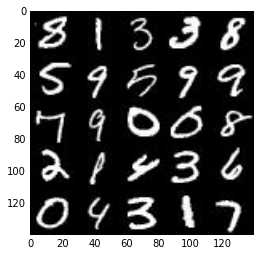

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

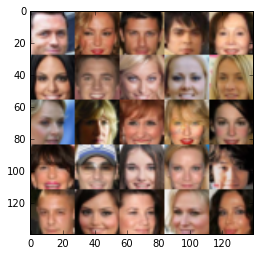

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 9.0538... Generator Loss: 0.0003
Epoch 1/2... Discriminator Loss: 0.0737... Generator Loss: 15.8452
Epoch 1/2... Discriminator Loss: 0.2299... Generator Loss: 1.9518
Epoch 1/2... Discriminator Loss: 0.0095... Generator Loss: 10.3215
Epoch 1/2... Discriminator Loss: 1.6230... Generator Loss: 1.1165
Epoch 1/2... Discriminator Loss: 0.3145... Generator Loss: 2.2372
Epoch 1/2... Discriminator Loss: 0.6078... Generator Loss: 2.3566
Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 5.3039
Epoch 1/2... Discriminator Loss: 0.8797... Generator Loss: 3.1414
Epoch 1/2... Discriminator Loss: 1.3504... Generator Loss: 0.7355


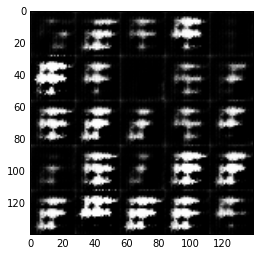

Epoch 1/2... Discriminator Loss: 2.7974... Generator Loss: 0.2353
Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 1.8765
Epoch 1/2... Discriminator Loss: 0.5733... Generator Loss: 1.7798
Epoch 1/2... Discriminator Loss: 0.8986... Generator Loss: 5.7277
Epoch 1/2... Discriminator Loss: 0.3148... Generator Loss: 2.7067
Epoch 1/2... Discriminator Loss: 0.3691... Generator Loss: 2.0191
Epoch 1/2... Discriminator Loss: 0.3617... Generator Loss: 2.8296
Epoch 1/2... Discriminator Loss: 0.4310... Generator Loss: 2.1243
Epoch 1/2... Discriminator Loss: 0.8817... Generator Loss: 1.2967
Epoch 1/2... Discriminator Loss: 0.3830... Generator Loss: 2.2666


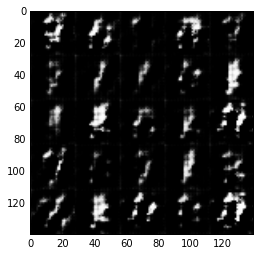

Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.0586
Epoch 1/2... Discriminator Loss: 0.4917... Generator Loss: 2.6672
Epoch 1/2... Discriminator Loss: 0.6421... Generator Loss: 3.7754
Epoch 1/2... Discriminator Loss: 0.2513... Generator Loss: 2.2011
Epoch 1/2... Discriminator Loss: 0.4678... Generator Loss: 1.5867
Epoch 1/2... Discriminator Loss: 0.4277... Generator Loss: 1.6921
Epoch 1/2... Discriminator Loss: 0.5209... Generator Loss: 1.4324
Epoch 1/2... Discriminator Loss: 0.6832... Generator Loss: 2.4677
Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 2.1685
Epoch 1/2... Discriminator Loss: 0.5902... Generator Loss: 1.5020


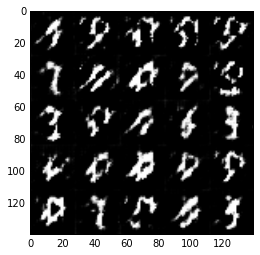

Epoch 1/2... Discriminator Loss: 0.5335... Generator Loss: 1.6490
Epoch 1/2... Discriminator Loss: 0.4746... Generator Loss: 3.9007
Epoch 1/2... Discriminator Loss: 0.8493... Generator Loss: 1.1698
Epoch 1/2... Discriminator Loss: 0.5357... Generator Loss: 1.6890
Epoch 1/2... Discriminator Loss: 0.9738... Generator Loss: 3.2774
Epoch 1/2... Discriminator Loss: 0.6145... Generator Loss: 1.9368
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 0.6759
Epoch 1/2... Discriminator Loss: 0.5430... Generator Loss: 1.9914
Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 1.0208
Epoch 1/2... Discriminator Loss: 0.6535... Generator Loss: 1.8759


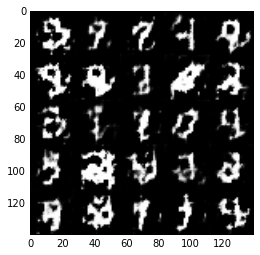

Epoch 1/2... Discriminator Loss: 0.6720... Generator Loss: 1.2416
Epoch 1/2... Discriminator Loss: 0.6613... Generator Loss: 1.7030
Epoch 1/2... Discriminator Loss: 0.8236... Generator Loss: 1.9250
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 0.8882... Generator Loss: 1.4020
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 1.5254
Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.5858
Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 0.9304
Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 0.9214
Epoch 1/2... Discriminator Loss: 1.2112... Generator Loss: 1.1652


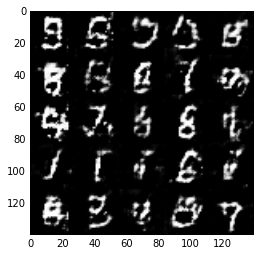

Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 0.8250
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 0.7749
Epoch 1/2... Discriminator Loss: 1.2118... Generator Loss: 0.6110
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 3.0596
Epoch 1/2... Discriminator Loss: 0.8095... Generator Loss: 1.2194
Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 0.9397
Epoch 1/2... Discriminator Loss: 1.5276... Generator Loss: 5.1092
Epoch 1/2... Discriminator Loss: 1.0890... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.4503
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 0.6999


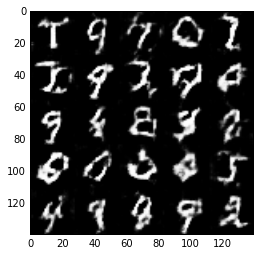

Epoch 1/2... Discriminator Loss: 0.9896... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 0.9991... Generator Loss: 0.7835
Epoch 1/2... Discriminator Loss: 0.8526... Generator Loss: 0.9683
Epoch 1/2... Discriminator Loss: 0.7136... Generator Loss: 2.1543
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 2.1605
Epoch 1/2... Discriminator Loss: 0.9065... Generator Loss: 1.3908
Epoch 1/2... Discriminator Loss: 2.2238... Generator Loss: 0.2144
Epoch 1/2... Discriminator Loss: 0.6256... Generator Loss: 1.8603
Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 1.2317


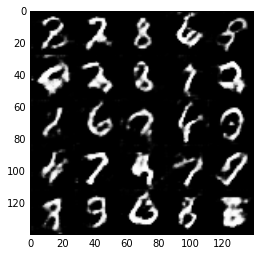

Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 3.8917
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 0.6095... Generator Loss: 1.4719
Epoch 1/2... Discriminator Loss: 0.8111... Generator Loss: 1.3721
Epoch 1/2... Discriminator Loss: 0.8410... Generator Loss: 1.0005
Epoch 1/2... Discriminator Loss: 1.3561... Generator Loss: 0.5034
Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 0.6820
Epoch 1/2... Discriminator Loss: 0.7867... Generator Loss: 1.8135
Epoch 1/2... Discriminator Loss: 0.8008... Generator Loss: 1.7191


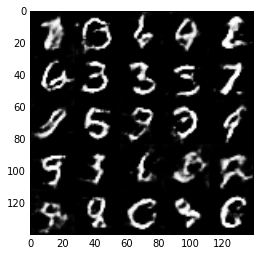

Epoch 1/2... Discriminator Loss: 1.5125... Generator Loss: 2.7616
Epoch 1/2... Discriminator Loss: 1.0023... Generator Loss: 1.0262
Epoch 1/2... Discriminator Loss: 0.7965... Generator Loss: 1.8022
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 2.0798
Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 0.8549
Epoch 1/2... Discriminator Loss: 1.8800... Generator Loss: 0.2686
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 2.8784
Epoch 1/2... Discriminator Loss: 1.3077... Generator Loss: 0.4716
Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 1.0367
Epoch 1/2... Discriminator Loss: 1.9450... Generator Loss: 0.2568


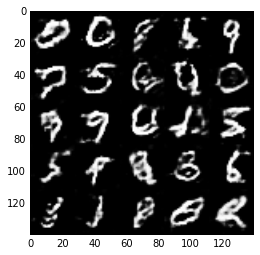

Epoch 1/2... Discriminator Loss: 1.6054... Generator Loss: 3.6585
Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 0.3772
Epoch 2/2... Discriminator Loss: 0.9451... Generator Loss: 1.0301
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.5092
Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 1.2751
Epoch 2/2... Discriminator Loss: 1.0380... Generator Loss: 0.6790
Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 1.7394
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 1.8238
Epoch 2/2... Discriminator Loss: 0.9609... Generator Loss: 0.8109


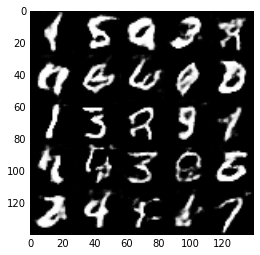

Epoch 2/2... Discriminator Loss: 1.9926... Generator Loss: 4.1647
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 0.8843
Epoch 2/2... Discriminator Loss: 0.8272... Generator Loss: 1.1876
Epoch 2/2... Discriminator Loss: 1.8844... Generator Loss: 0.2529
Epoch 2/2... Discriminator Loss: 0.9018... Generator Loss: 1.1878
Epoch 2/2... Discriminator Loss: 1.4328... Generator Loss: 0.4553
Epoch 2/2... Discriminator Loss: 1.1966... Generator Loss: 0.6605
Epoch 2/2... Discriminator Loss: 0.8553... Generator Loss: 1.3907
Epoch 2/2... Discriminator Loss: 1.5458... Generator Loss: 0.3546
Epoch 2/2... Discriminator Loss: 0.8504... Generator Loss: 1.8448


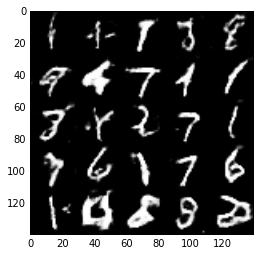

Epoch 2/2... Discriminator Loss: 1.0622... Generator Loss: 1.5983
Epoch 2/2... Discriminator Loss: 0.9476... Generator Loss: 0.8994
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 0.4265
Epoch 2/2... Discriminator Loss: 1.6956... Generator Loss: 0.3459
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 0.7848
Epoch 2/2... Discriminator Loss: 1.0660... Generator Loss: 1.7481
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.5145
Epoch 2/2... Discriminator Loss: 1.1247... Generator Loss: 1.9356
Epoch 2/2... Discriminator Loss: 1.8614... Generator Loss: 0.2391
Epoch 2/2... Discriminator Loss: 1.1837... Generator Loss: 0.6526


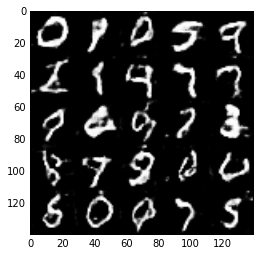

Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 1.4989
Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 1.1168
Epoch 2/2... Discriminator Loss: 0.7953... Generator Loss: 1.6146
Epoch 2/2... Discriminator Loss: 1.4451... Generator Loss: 0.4021
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 0.9225
Epoch 2/2... Discriminator Loss: 1.1789... Generator Loss: 0.5561
Epoch 2/2... Discriminator Loss: 1.9223... Generator Loss: 0.2498
Epoch 2/2... Discriminator Loss: 1.9932... Generator Loss: 0.2564
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.4420
Epoch 2/2... Discriminator Loss: 0.8409... Generator Loss: 0.8663


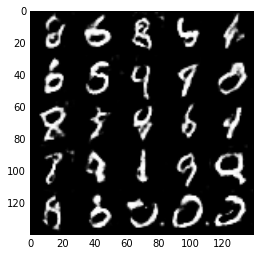

Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 0.8394
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 1.5381
Epoch 2/2... Discriminator Loss: 0.8043... Generator Loss: 0.9586
Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 0.5308
Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.4916
Epoch 2/2... Discriminator Loss: 0.9787... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 2.0013... Generator Loss: 0.2404
Epoch 2/2... Discriminator Loss: 0.9464... Generator Loss: 1.0544
Epoch 2/2... Discriminator Loss: 1.1000... Generator Loss: 0.6985
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 0.8186


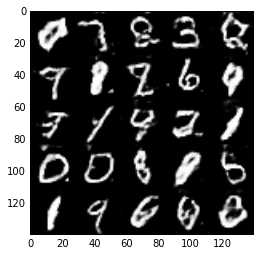

Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 0.5503
Epoch 2/2... Discriminator Loss: 1.2558... Generator Loss: 0.5431
Epoch 2/2... Discriminator Loss: 1.8599... Generator Loss: 0.2779
Epoch 2/2... Discriminator Loss: 1.1473... Generator Loss: 0.6588
Epoch 2/2... Discriminator Loss: 0.5626... Generator Loss: 1.5523
Epoch 2/2... Discriminator Loss: 0.8661... Generator Loss: 3.1541
Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 0.4960
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 2.7618


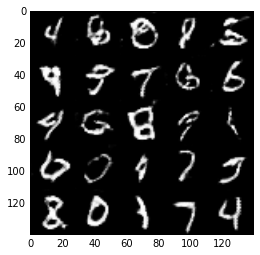

Epoch 2/2... Discriminator Loss: 0.7559... Generator Loss: 1.0596
Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 2.8592
Epoch 2/2... Discriminator Loss: 1.0907... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.0123... Generator Loss: 2.1992
Epoch 2/2... Discriminator Loss: 0.7139... Generator Loss: 1.4242
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 0.9165
Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 1.2606
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.0573
Epoch 2/2... Discriminator Loss: 0.8184... Generator Loss: 0.8988
Epoch 2/2... Discriminator Loss: 2.5702... Generator Loss: 0.1480


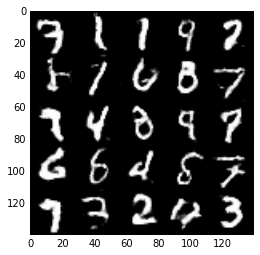

Epoch 2/2... Discriminator Loss: 1.5942... Generator Loss: 0.3965
Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 1.6801
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 1.0303
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 0.5371
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 1.0888
Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 1.2861
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.5126
Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 1.1037
Epoch 2/2... Discriminator Loss: 2.2151... Generator Loss: 4.3339


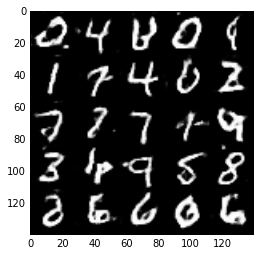

Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 1.6368
Epoch 2/2... Discriminator Loss: 2.2353... Generator Loss: 0.1792
Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 0.7146
Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 0.8607
Epoch 2/2... Discriminator Loss: 0.5587... Generator Loss: 1.9410
Epoch 2/2... Discriminator Loss: 0.7831... Generator Loss: 2.0589
Epoch 2/2... Discriminator Loss: 0.5436... Generator Loss: 1.4473
Epoch 2/2... Discriminator Loss: 0.8924... Generator Loss: 0.8775
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.5767
Epoch 2/2... Discriminator Loss: 1.3831... Generator Loss: 3.2873


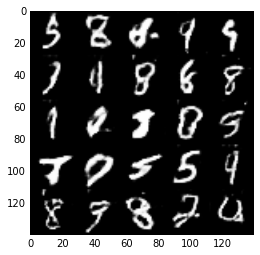

Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 0.3236... Generator Loss: 2.3004
Epoch 2/2... Discriminator Loss: 0.3894... Generator Loss: 2.8841
Epoch 2/2... Discriminator Loss: 0.9346... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 0.9685... Generator Loss: 1.5503
Epoch 2/2... Discriminator Loss: 1.2473... Generator Loss: 0.6109
Epoch 2/2... Discriminator Loss: 0.9372... Generator Loss: 1.5476


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 0.2155... Generator Loss: 2.2796
Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 3.2457
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 2.9544
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.4245
Epoch 1/1... Discriminator Loss: 2.6074... Generator Loss: 0.2029
Epoch 1/1... Discriminator Loss: 4.3343... Generator Loss: 10.7302
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 1.7455
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 3.2257


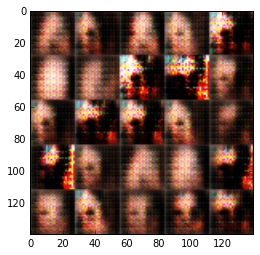

Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 1.7761
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 2.1673
Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 1.4813
Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 2.0231
Epoch 1/1... Discriminator Loss: 0.6243... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.7777... Generator Loss: 0.2385
Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 2.5454


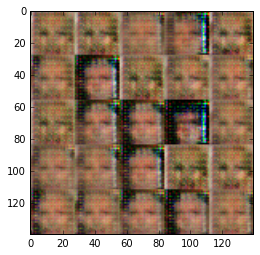

Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 1.2091
Epoch 1/1... Discriminator Loss: 0.7719... Generator Loss: 1.7830
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.6198... Generator Loss: 1.8074
Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.3401
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.5500


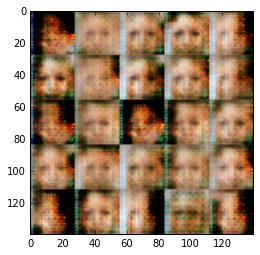

Epoch 1/1... Discriminator Loss: 2.3849... Generator Loss: 4.0280
Epoch 1/1... Discriminator Loss: 1.7268... Generator Loss: 0.3701
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 3.4934
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 1.2491
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.9280... Generator Loss: 1.6663
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 1.8353
Epoch 1/1... Discriminator Loss: 1.5729... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.8801


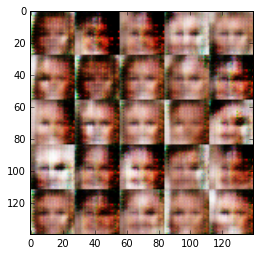

Epoch 1/1... Discriminator Loss: 2.7348... Generator Loss: 0.1201
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 1.4548
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 1.3417
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.3772
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.4257
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.4918


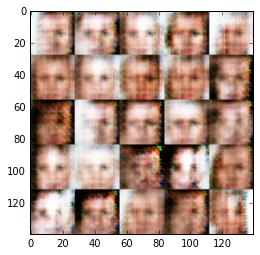

Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.3330
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.7576... Generator Loss: 0.3491
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 1.2427
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 1.6107
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 0.7272


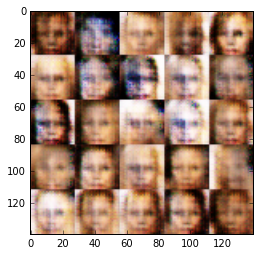

Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.7485... Generator Loss: 2.4497
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 1.2251
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.1554


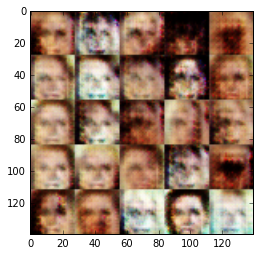

Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.0219
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 1.4734
Epoch 1/1... Discriminator Loss: 3.3817... Generator Loss: 3.6829
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.3008
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 2.1041
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.2223
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.4604


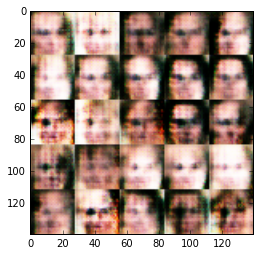

Epoch 1/1... Discriminator Loss: 1.8163... Generator Loss: 0.3292
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 1.6480... Generator Loss: 0.3086
Epoch 1/1... Discriminator Loss: 1.5828... Generator Loss: 1.3381


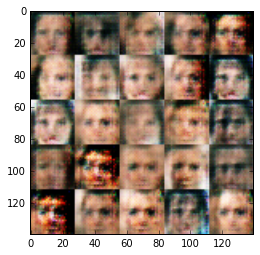

Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.1166
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.2289


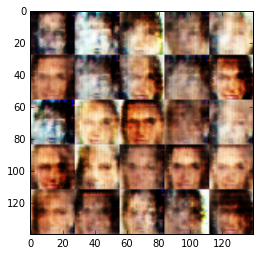

Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.3555
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 2.0287
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.8530


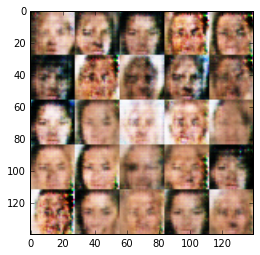

Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.5788


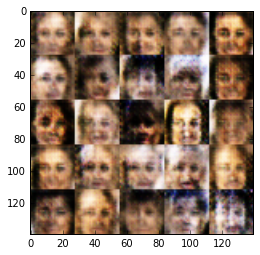

Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 1.5566
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.4064
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 1.5228
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.3799
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 1.0256


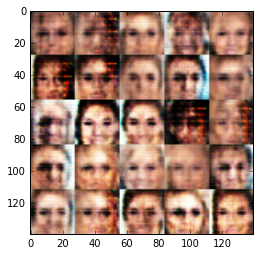

Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.3865
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.6862
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 2.1018
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.3842
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.0340


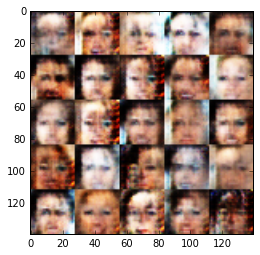

Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.7730
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.4168
Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.3580


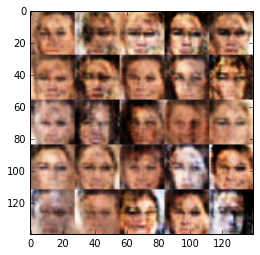

Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 1.8587
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 0.9938


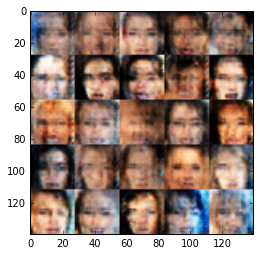

Epoch 1/1... Discriminator Loss: 1.9014... Generator Loss: 0.2945
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 1.5355
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 1.9467... Generator Loss: 3.0360
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 1.0941


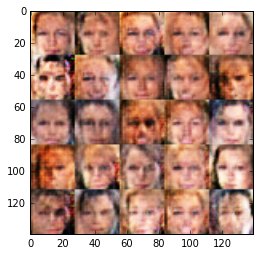

Epoch 1/1... Discriminator Loss: 0.6941... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 1.8625... Generator Loss: 0.2673
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.4203
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.6614
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 0.8719


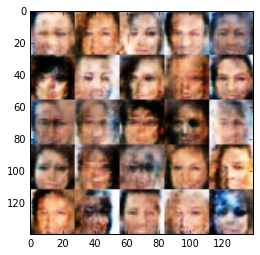

Epoch 1/1... Discriminator Loss: 1.8385... Generator Loss: 3.1335
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 1.2974
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.7561


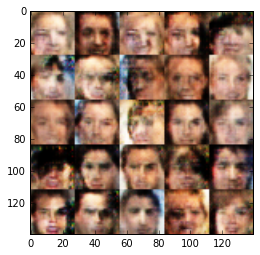

Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.5955... Generator Loss: 0.3885
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 1.6587
Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 1.7194
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.5205


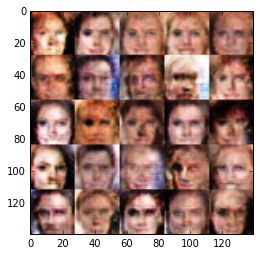

Epoch 1/1... Discriminator Loss: 1.7070... Generator Loss: 0.3139
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 1.8878
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.7428
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 0.9974


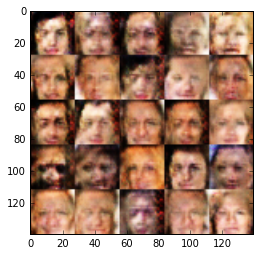

Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.5080
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.1742
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 2.0645
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.3720
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.6946


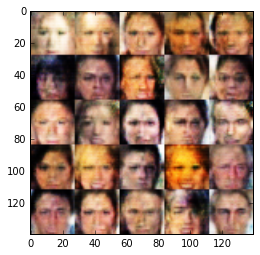

Epoch 1/1... Discriminator Loss: 2.1159... Generator Loss: 0.2289
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 1.4132
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.2889
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.6077


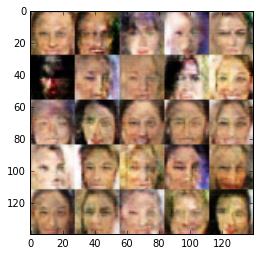

Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 2.2571
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 1.4951
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.5005


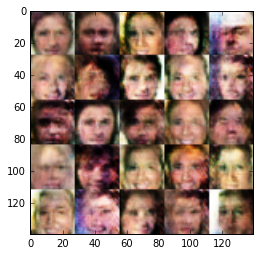

Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 1.8100
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.3348
Epoch 1/1... Discriminator Loss: 1.8197... Generator Loss: 2.2423
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 1.6903
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.1308


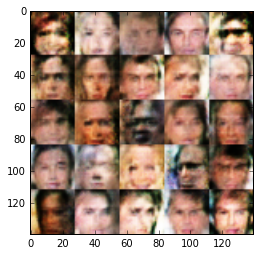

Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 1.4393
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.6951


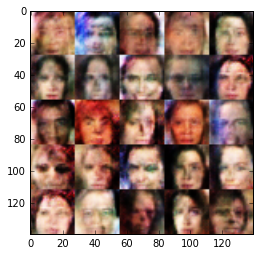

Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.4053
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.4578
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.2478
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 2.3071
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.2502
Epoch 1/1... Discriminator Loss: 1.6591... Generator Loss: 0.3530
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 1.1639


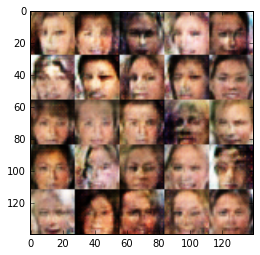

Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.2897
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 2.2542
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.5041
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.7798
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.2044
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.1897


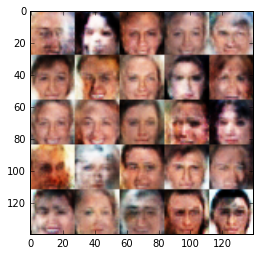

Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.9240
Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 2.3453
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.3427
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.0894
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.4665
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.7753... Generator Loss: 0.3035
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.6317


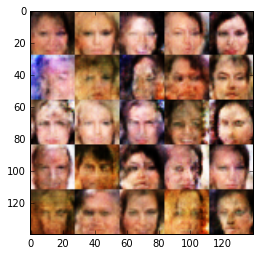

Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 1.9798
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 1.2488
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.1740
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.1361


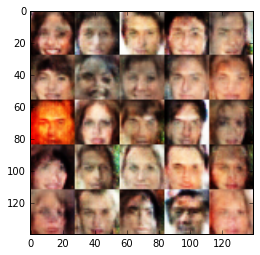

Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.3377
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 1.9146
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.5102
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 0.6778... Generator Loss: 1.5368
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.3688


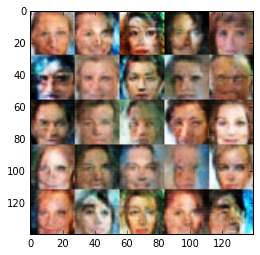

Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.3457


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.